In [53]:
import pymongo as pm
import ssl, certifi
from datetime import datetime, timedelta, timezone
import numpy as np
import matplotlib.pyplot as plt

In [54]:
USER = "ictts"
PWD  = "Ict4SM22!"
HOST = "bigdatadb.polito.it"
PORT = 27017
DB   = "carsharing"

client = pm.MongoClient(HOST,
ssl=True, #there might be conflicts, try to set to False
authSource = DB,
username = USER,
password =PWD,
port=PORT,
tlsAllowInvalidCertificates=True)

db = client[DB]
db.list_collection_names()

['enjoy_DebugInfo',
 'ictts_PermanentBookings',
 'ictts_enjoy_PermanentBookings',
 'enjoy_PermanentBookings',
 'BigDive7_PermanentBookings',
 'enjoy_ActiveParkings',
 'test_collection',
 'DebugInfo',
 'PermanentBookings',
 'PermanentParkings',
 'system.js',
 'ActiveParkings',
 'enjoy_PermanentParkings',
 'hexs_gen',
 'enjoy_ActiveBookings',
 'ActiveBookings']

**PART 1:**  
**Check if the booking records requires to be filtered to get valid rentals**

In [55]:
collections = ["ictts_PermanentBookings", "ictts_enjoy_PermanentBookings"]
city = "Torino"

In [56]:
# query to get the booking records in Turin and evaluate its duration by subtracting the start time from the end time
pipeline = [
    {
        "$match": {
            "city": city
        }
    },
    {
        "$project": {
            "init_loc": 1,
            "final_loc": 1,
            "duration": {
                "$subtract": ["$final_time", "$init_time"]
            }
        }
    }
]

car2go_booking_durations = list(db["ictts_PermanentBookings"].aggregate(pipeline))
enjoy_booking_durations = list(db["ictts_enjoy_PermanentBookings"].aggregate(pipeline))

booking_records = car2go_booking_durations + enjoy_booking_durations

# filter out records outside the 2 minutes and 1 hour range
booking_records = [record for record in booking_records if 120 <= record["duration"] <= 3600]

# print booking records structure
print(booking_records[0])

{'_id': ObjectId('5a3bb3af20c3dd47cf59003d'), 'final_loc': {'coordinates': [7.68634, 45.07567], 'type': 'Point'}, 'init_loc': {'coordinates': [7.68486, 45.08276], 'type': 'Point'}, 'duration': 1215}


/tmp/ipykernel_58/1970140351.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


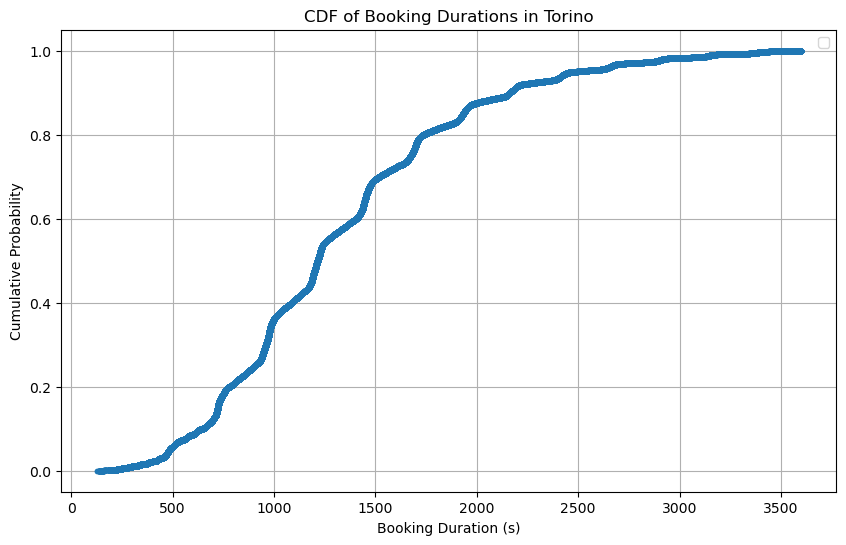

In [57]:
# plot the CDF of the booking durations
plt.figure(figsize=(10,6))
plt.plot(np.sort([record['duration'] for record in booking_records]), np.linspace(0, 1, len(booking_records)), marker='.', linestyle='none')
plt.xlabel('Booking Duration (s)')
plt.ylabel('Cumulative Probability')
# plt.axvline(x=3600, color='r', linestyle='--', label='1 hour')
# plt.axvline(x=120, color='g', linestyle='--', label='2 minutes')
plt.title(f'CDF of Booking Durations in {city}')
plt.grid()
plt.legend()
plt.show()

The CDF of the durations of all the bookings in Torino shows no need to filter the records, since almost all the bookings have a duration in the outlier range used in the first lab [2 - 60 minutes].

**Derive the OD matrix based on the zones of Torino**  

Compares:  
- Weekdays (Monday to Friday) in day time (8am - 8pm) and Weekends (Saturday and Sunday) in day time (8am - 8pm)
- Car2go weekdays in day time vs Enjoy weekdays in day time

In [ ]:
!pip install geojson
!pip install shapely

In [89]:
# query the db and create a dataframe mapping all the points to their zones
import geojson
import pandas as pd

with open(r"./Lab2/TorinoZonescol.geojson") as f:
    gj = geojson.load(f)

    zones = len(gj['features'])
    total_bookings = pd.DataFrame()

    for i in range(zones):
        for j in range(zones):
            zone_i = gj['features'][i]['geometry']['coordinates']
            zone_j = gj['features'][j]['geometry']['coordinates']

            pipeline = [
                {
                    "$match": {
                        "city": city,
                        "init_loc": {
                            "$geoWithin": {
                                "$geometry": {
                                    "type": "MultiPolygon",
                                    "coordinates": zone_i
                                }
                            }
                        },
                        "final_loc": {
                            "$geoWithin": {
                                "$geometry": {
                                    "type": "MultiPolygon",
                                    "coordinates": zone_j
                                }
                            }
                        }
                    }
                },
                {
                    "$project": {
                        "init_loc": 1,
                        "final_loc": 1,
                        "init_date": 1,
                        "final_date": 1,
                        "init_time": 1,
                        "final_time": 1,
                        "duration": {
                            "$subtract": ["$final_time", "$init_time"]
                        }
                    }
                },
                {
                    "$addFields": {
                        "zone_init": i,
                        "zone_final": j
                    }
                }
            ]

            car2go_bookings = list(db["ictts_PermanentBookings"].aggregate(pipeline))
            # convert to dataframe
            car2go_df = pd.DataFrame(car2go_bookings)
            # add service column
            car2go_df['service'] = 'car2go'
            enjoy_bookings = list(db["ictts_enjoy_PermanentBookings"].aggregate(pipeline))
            enjoy_df = pd.DataFrame(enjoy_bookings)
            enjoy_df['service'] = 'enjoy'

            total_bookings = pd.concat([total_bookings, car2go_df, enjoy_df], ignore_index=True)

In [90]:
total_bookings.head()

,_id,final_date,final_loc,init_time,init_loc,final_time,init_date,duration,zone_init,zone_final,service
0,5a3bb3af20c3dd47cf59bf70,2017-10-10 15:54:54,"{'coordinates': [7.68711, 45.06589], 'type': '...",1.507643e+09,"{'coordinates': [7.67469, 45.07686], 'type': '...",1.507644e+09,2017-10-10 15:39:16,938.0,0.0,0.0,car2go
1,5a3bb3af20c3dd47cf5925f0,2017-10-27 15:00:43,"{'coordinates': [7.66775, 45.07001], 'type': '...",1.509108e+09,"{'coordinates': [7.67485, 45.07696], 'type': '...",1.509109e+09,2017-10-27 14:41:13,1170.0,0.0,0.0,car2go
2,5a3bb3af20c3dd47cf599f7b,2017-10-13 22:45:40,"{'coordinates': [7.67999, 45.05962], 'type': '...",1.507926e+09,"{'coordinates': [7.67484, 45.07694], 'type': '...",1.507928e+09,2017-10-13 22:23:44,1316.0,0.0,0.0,car2go
3,5a3bb3b020c3dd47cf5aaf22,2017-09-09 22:13:50,"{'coordinates': [7.68662, 45.06017], 'type': '...",1.504986e+09,"{'coordinates': [7.67665, 45.07671], 'type': '...",1.504988e+09,2017-09-09 21:35:32,2298.0,0.0,0.0,car2go
4,5a3bb3b020c3dd47cf5a7e0f,2017-09-16 08:07:39,"{'coordinates': [7.68419, 45.06067], 'type': '...",1.505542e+09,"{'coordinates': [7.67633, 45.0768], 'type': 'P...",1.505542e+09,2017-09-16 08:00:19,440.0,0.0,0.0,car2go


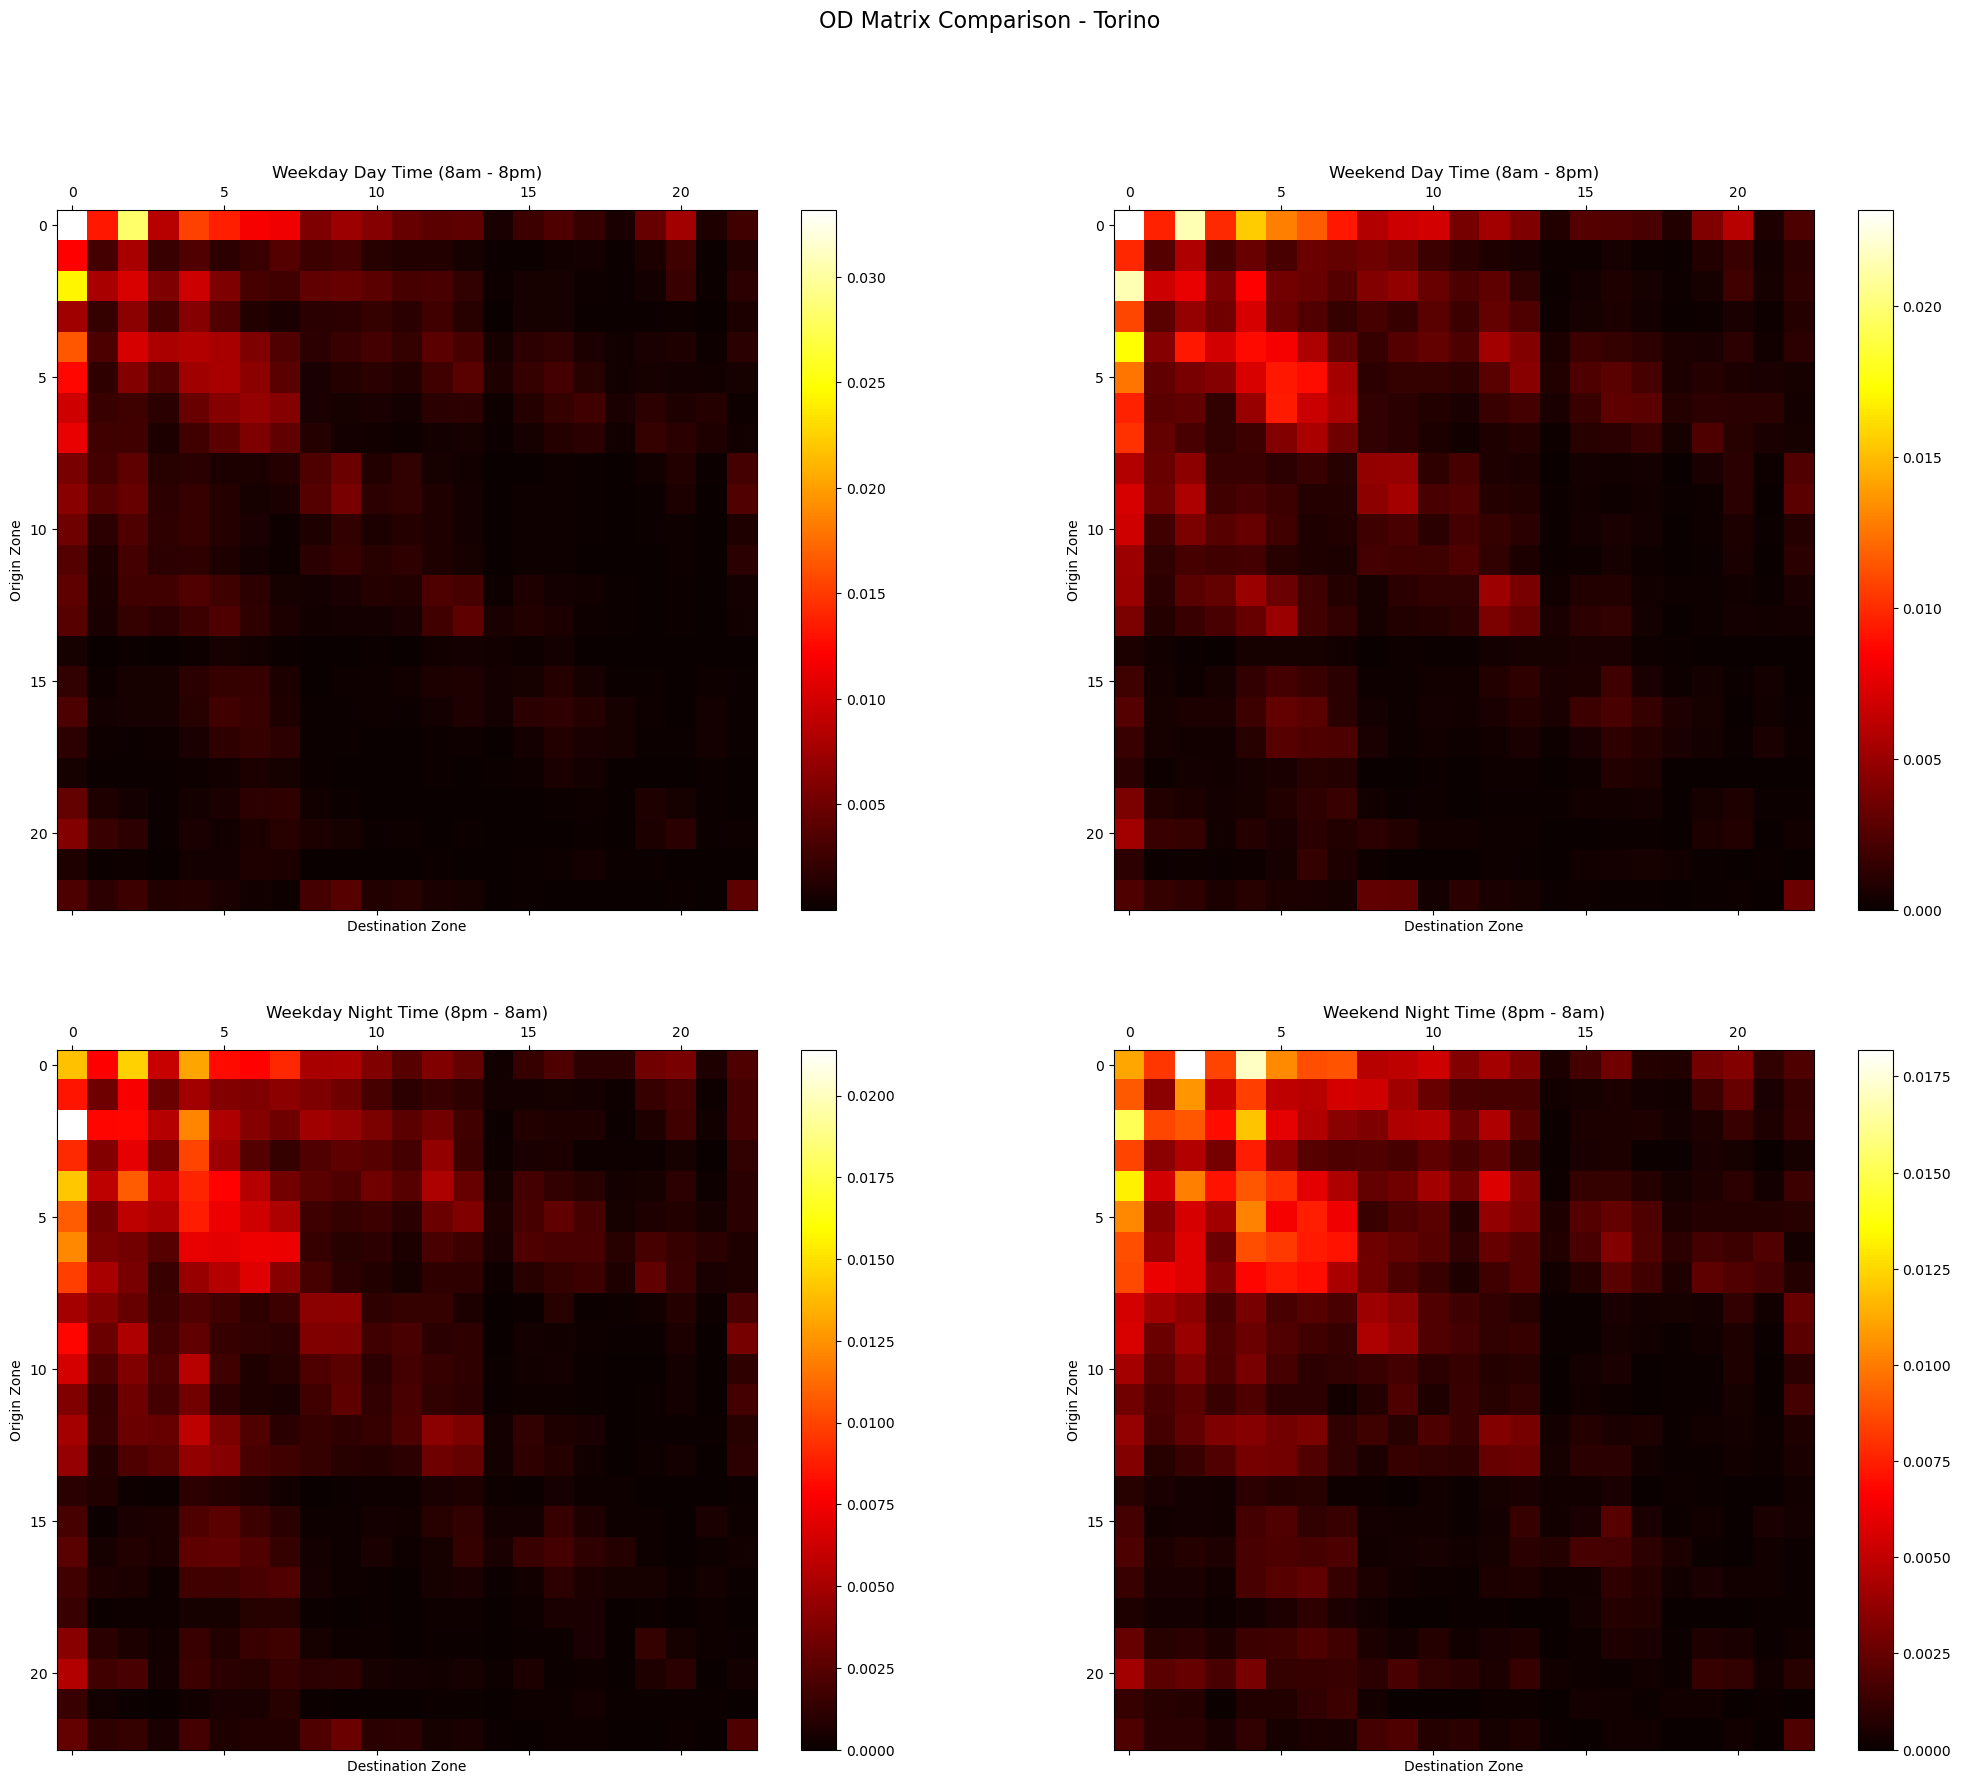

In [96]:
# create the OD matrix of bookings between zones, filter data per weekdays (Monday to Friday) day/night time and weekends (Saturday and Sunday) in day/night time
od_matrix_weekday_day = np.zeros((zones, zones))
od_matrix_weekday_night = np.zeros((zones, zones))
od_matrix_weekend_day = np.zeros((zones, zones))
od_matrix_weekend_night = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])

    # convert init_time to datetime object
    if init_date.weekday() < 5:  # Weekday
        if 8 <= init_date.hour < 20:  # Day time
            od_matrix_weekday_day[zone_init][zone_final] += 1
        else:  # Night time
            od_matrix_weekday_night[zone_init][zone_final] += 1
    else:  # Weekend
        if 8 <= init_date.hour < 20:  # Day time
            od_matrix_weekend_day[zone_init][zone_final] += 1
        else:  # Night time
            od_matrix_weekend_night[zone_init][zone_final] += 1

# normalize the OD matrices
od_matrix_weekday_day /= np.sum(od_matrix_weekday_day)
od_matrix_weekday_night /= np.sum(od_matrix_weekday_night)
od_matrix_weekend_day /= np.sum(od_matrix_weekend_day)
od_matrix_weekend_night /= np.sum(od_matrix_weekend_night)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(2, 2, figsize=(25, 20))
fig.suptitle(f'OD Matrix Comparison - {city}', fontsize=16)

titles = {
    'Weekday Day Time (8am - 8pm)': od_matrix_weekday_day,
    'Weekend Day Time (8am - 8pm)': od_matrix_weekend_day,
    'Weekday Night Time (8pm - 8am)': od_matrix_weekday_night,
    'Weekend Night Time (8pm - 8am)': od_matrix_weekend_night
}

for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()


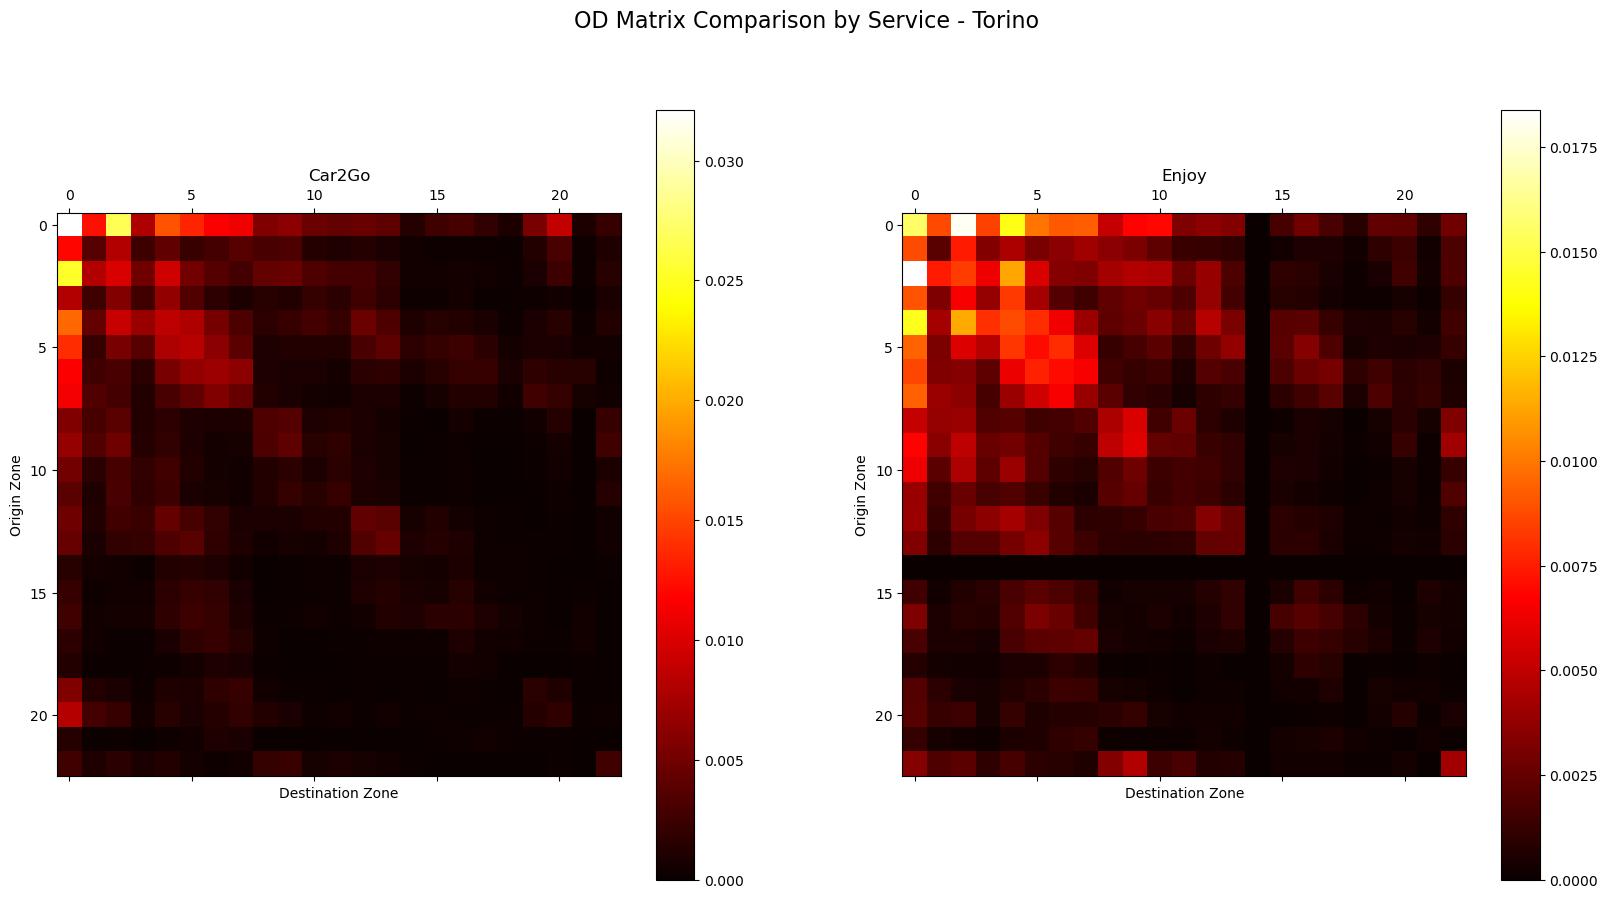

In [97]:
# create the OD matrix for the bookings of car2go and enjoy between zones
od_matrix_car2go = np.zeros((zones, zones))
od_matrix_enjoy = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])
    service = row['service']

    if service == 'car2go':
        od_matrix_car2go[zone_init][zone_final] += 1
    elif service == 'enjoy':
        od_matrix_enjoy[zone_init][zone_final] += 1
# normalize the OD matrices
od_matrix_car2go /= np.sum(od_matrix_car2go)
od_matrix_enjoy /= np.sum(od_matrix_enjoy)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'OD Matrix Comparison by Service - {city}', fontsize=16)
titles = {
    'Car2Go': od_matrix_car2go,
    'Enjoy': od_matrix_enjoy
}
for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

In [108]:
print("Date range in total_bookings:")
print(f"Min date: {total_bookings['init_date'].min()}")
print(f"Max date: {total_bookings['init_date'].max()}")

Date range in total_bookings:
Min date: 2017-09-01 00:00:03
Max date: 2017-10-31 23:59:30


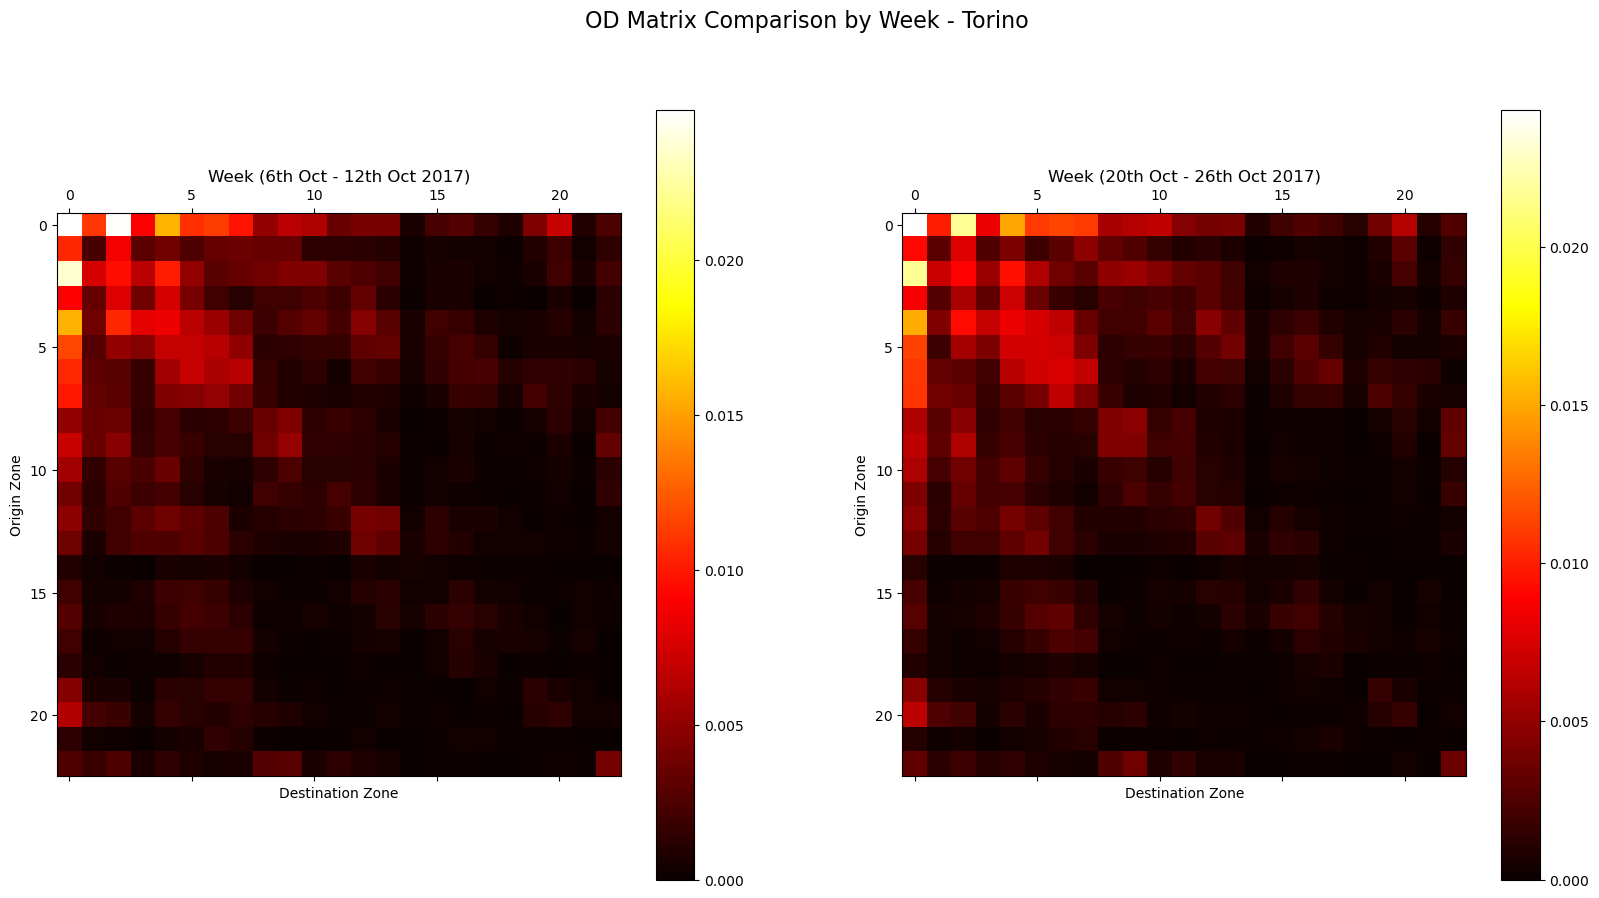

In [111]:
# evaluate the OD matrix for the bookings in different weeks of the dataset

# week1 : from 6th Oct 2017 to 12th Oct 2017
# week2 : from 20th Oct 2017 to 26th Oct 2017

od_matrix_week1 = np.zeros((zones, zones))
od_matrix_week2 = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])

    if datetime(2017, 10, 6) <= init_date < datetime(2017, 10, 13):
        od_matrix_week1[zone_init][zone_final] += 1
    elif datetime(2017, 10, 20) <= init_date < datetime(2017, 10, 27):
        od_matrix_week2[zone_init][zone_final] += 1    

# normalize the OD matrices
od_matrix_week1 /= np.sum(od_matrix_week1)
od_matrix_week2 /= np.sum(od_matrix_week2)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'OD Matrix Comparison by Week - {city}', fontsize=16)
titles = {
    'Week (6th Oct - 12th Oct 2017)': od_matrix_week1,
    'Week (20th Oct - 26th Oct 2017)': od_matrix_week2
}
for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

Plot the geojson of the zones of Torino

In [41]:
!pip install contextily

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached rasterio-1.4.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached geographiclib-2.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.1-py3-none-any.whl (40 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Using cached rasterio-1.4.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [contextily]8 [geopy]i

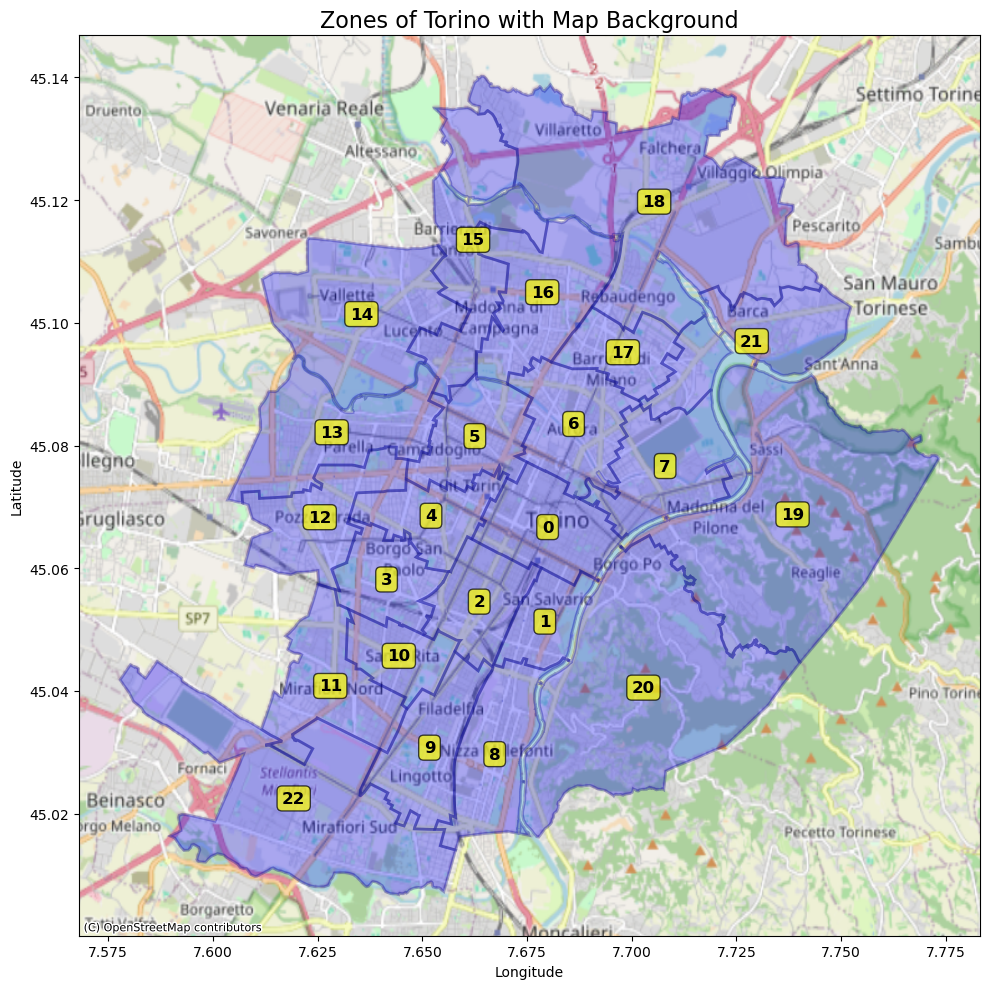

In [71]:
# plot the zones of the geojson file with map background and zone numbers

import matplotlib.pyplot as plt
from shapely.geometry import shape
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))

# Plot each zone
for idx, feature in enumerate(gj['features']):
    geom = shape(feature['geometry'])
    
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.fill(x, y, alpha=0.3, fc='blue', ec='darkblue', linewidth=2)
        # Calculate centroid for zone number
        centroid = geom.centroid
        ax.text(centroid.x, centroid.y, str(idx), fontsize=12, 
                ha='center', va='center', weight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    elif geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, alpha=0.3, fc='blue', ec='darkblue', linewidth=2)
        # Calculate centroid for zone number
        centroid = geom.centroid
        ax.text(centroid.x, centroid.y, str(idx), fontsize=12, 
                ha='center', va='center', weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_title('Zones of Torino with Map Background', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add basemap (OpenStreetMap)
try:
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
except:
    print("Could not load basemap. Install contextily: pip install contextily")

plt.tight_layout()
plt.show()

**Derive metrics to compute similarity between the OD matrices**

In [112]:
# compute the distance between matrices by using Manhattan, Euclidean, maximum distance, spetral norm

def manhattan_distance(mat1, mat2):
    return np.sum(np.abs(mat1 - mat2))

def euclidean_distance(mat1, mat2):
    return np.sqrt(np.sum((mat1 - mat2) ** 2))

def maximum_distance(mat1, mat2):
    return np.max(np.abs(mat1 - mat2))

def spectral_distance(mat1, mat2):
    return np.linalg.norm(mat1 - mat2, 2)

# evaluate distances between weekday day and night matrices
print("Distances between Weekday Day and Night OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_weekday_day, od_matrix_weekday_night)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_weekday_day, od_matrix_weekday_night)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_weekday_day, od_matrix_weekday_night)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_weekday_day, od_matrix_weekday_night)}")

# evaluate distances between weekday day and weekend day matrices
print("\nDistances between Weekday Day and Weekend Day OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_weekday_day, od_matrix_weekend_day)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_weekday_day, od_matrix_weekend_day)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_weekday_day, od_matrix_weekend_day)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_weekday_day, od_matrix_weekend_day)}")

# evaluate distances between car2go and enjoy matrices
print("\nDistances between Car2Go and Enjoy OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_car2go, od_matrix_enjoy)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_car2go, od_matrix_enjoy)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_car2go, od_matrix_enjoy)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_car2go, od_matrix_enjoy)}")

# evaluate distances between week1 and week2 matrices
print("\nDistances between Week (6th Oct - 12th Oct 2017) and Week (20th Oct - 26th Oct 2017) OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_week1, od_matrix_week2)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_week1, od_matrix_week2)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_week1, od_matrix_week2)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_week1, od_matrix_week2)}")


Distances between Weekday Day and Night OD Matrices:
Manhattan Distance: 0.2688868510290505
Euclidean Distance: 0.030088770914985345
Maximum Distance: 0.019193342664937073
Spectral Distance: 0.02710394991031766

Distances between Weekday Day and Weekend Day OD Matrices:
Manhattan Distance: 0.19029194364047586
Euclidean Distance: 0.017956022679130743
Maximum Distance: 0.009997825014083389
Spectral Distance: 0.014656788394353587

Distances between Car2Go and Enjoy OD Matrices:
Manhattan Distance: 0.3006234895542417
Euclidean Distance: 0.027888456656949986
Maximum Distance: 0.016547215347710434
Spectral Distance: 0.024312600482193265

Distances between Week (6th Oct - 12th Oct 2017) and Week (20th Oct - 26th Oct 2017) OD Matrices:
Manhattan Distance: 0.14645874109767354
Euclidean Distance: 0.009848598019599236
Maximum Distance: 0.0029112994423846662
Spectral Distance: 0.005486506692093042
